In [12]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-18 19:29:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4007:826::2010, 2404:6800:4007:824::2010, 2404:6800:4007:827::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4007:826::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  19.4MB/s    in 5.7s    

2023-06-18 19:29:27 (14.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:

from tensorflow.keras.applications.inception_v3 import InceptionV3


local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

2023-06-18 19:29:54.741797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:

def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False



  return pre_trained_model

In [5]:


pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

2023-06-18 19:30:57.120032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-18 19:30:57.120132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [7]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85):
      print("\nReached 85.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [15]:
!unzip 'archive.zip'

Archive:  archive.zip
  inflating: images/images/train/angry/0.jpg  
  inflating: images/images/train/angry/1.jpg  
  inflating: images/images/train/angry/10.jpg  
  inflating: images/images/train/angry/10002.jpg  
  inflating: images/images/train/angry/10016.jpg  
  inflating: images/images/train/angry/10037.jpg  
  inflating: images/images/train/angry/10038.jpg  
  inflating: images/images/train/angry/10057.jpg  
  inflating: images/images/train/angry/10063.jpg  
  inflating: images/images/train/angry/10069.jpg  
  inflating: images/images/train/angry/10100.jpg  
  inflating: images/images/train/angry/10105.jpg  
  inflating: images/images/train/angry/10115.jpg  
  inflating: images/images/train/angry/10122.jpg  
  inflating: images/images/train/angry/10142.jpg  
  inflating: images/images/train/angry/1015.jpg  
  inflating: images/images/train/angry/10154.jpg  
  inflating: images/images/train/angry/10155.jpg  
  inflating: images/images/train/angry/10158.jpg  
  inflating: images/i

In [16]:
train_dir = 'images/train'
validation_dir = 'images/validation'

In [17]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator( rescale = 1.0/255. )



  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  validation_datagen = ImageDataGenerator ( rescale = 1.0/255. )


  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                               
                                                                class_mode='categorical',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

In [18]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [19]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  return last_output

In [20]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [21]:

def create_final_model(pre_trained_model, last_output):

  x = layers.Flatten()(last_output)

  x = layers.Dense(512, activation='relu')(x)

  x = layers.Dropout(.2)(x) 

  x = layers.Dense(7, activation='softmax')(x)     

  model = Model(pre_trained_model.input, x)

  
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  
  
  return model

In [22]:
model = create_final_model(pre_trained_model, last_output)


total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 28,246,951 total parameters in this model.
There are 19,271,687 trainable parameters in this model.


In [24]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/100
  2/901 [..............................] - ETA: 50s - loss: 1.4557 - accuracy: 0.4688 

2023-06-18 19:42:47.217815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


901/901 [==============================] - ETA: 0s - loss: 1.2724 - accuracy: 0.5360

2023-06-18 19:43:35.592420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-18 19:43:35.925767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


901/901 [==============================] - 59s 65ms/step - loss: 1.2724 - accuracy: 0.5360 - val_loss: 1.2280 - val_accuracy: 0.5505
Epoch 2/100
901/901 [==============================] - 57s 63ms/step - loss: 1.1120 - accuracy: 0.5958 - val_loss: 1.2352 - val_accuracy: 0.5616
Epoch 3/100
901/901 [==============================] - 57s 63ms/step - loss: 1.0077 - accuracy: 0.6313 - val_loss: 1.1453 - val_accuracy: 0.5910
Epoch 4/100
901/901 [==============================] - 58s 64ms/step - loss: 0.9159 - accuracy: 0.6679 - val_loss: 1.2058 - val_accuracy: 0.5727
Epoch 5/100
901/901 [==============================] - 57s 63ms/step - loss: 0.8409 - accuracy: 0.6966 - val_loss: 1.2697 - val_accuracy: 0.5552
Epoch 6/100
901/901 [==============================] - 57s 63ms/step - loss: 0.7862 - accuracy: 0.7185 - val_loss: 1.2092 - val_accuracy: 0.5876
Epoch 7/100
901/901 [==============================] - 57s 64ms/step - loss: 0.7304 - accuracy: 0.7384 - val_loss: 1.2579 - val_accuracy: 0.59

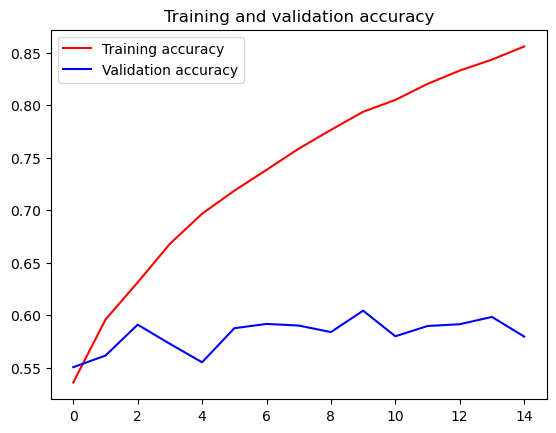

<Figure size 640x480 with 0 Axes>

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()